In [30]:
%load_ext autoreload
%autoreload 2
from plot import *
import os
import sys

sys.path.append(os.path.abspath('../'))
from analysis_util import *

from norm import read_norm_data
from sgd_weights import sgd_weights


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
results_path = '../../results/bloat-then-min-prune/conditions/bloat-then-min-prune-64-0/run_18245290851331019246'

In [32]:
genomes_by_batch, config = get_cppns_by_batch(results_path, 10)

 12%|█▏        | 5/41 [00:02<00:15,  2.35it/s]


Loaded 5 genomes


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = load_inputs(results_path, device)
target = load_target(results_path, config)
norm = read_norm_data(os.path.join("../", config.norm_df_path), config.target_name)
   
print(inputs.shape)

torch.Size([128, 128, 131])


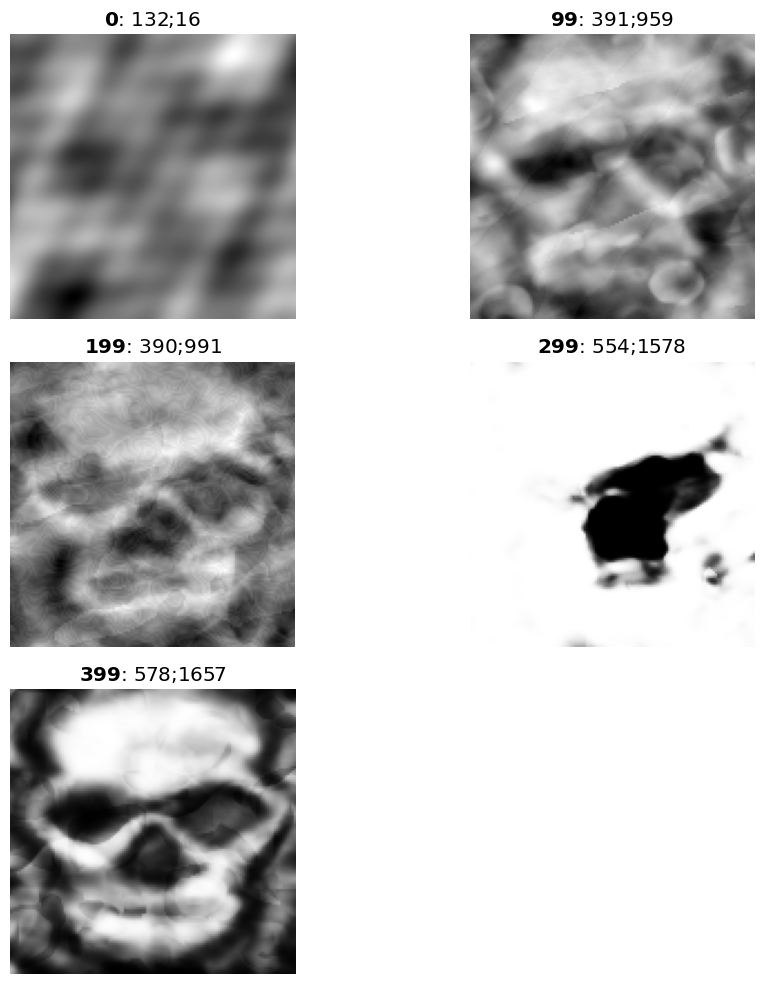

In [34]:
show_img_progression(genomes_by_batch, inputs)

In [40]:
import torch

num_steps = 500
config.sgd_steps = num_steps

def get_sgd_loss(cppn):
    losses = torch.zeros(num_steps)
    sgd_weights([cppn], None, inputs, target, config.objective_functions, norm, config, None, losses)
    return losses

In [42]:
all_losses = torch.ones(len(genomes_by_batch), num_steps) * -torch.inf
for batch, cppn in genomes_by_batch.items():
    all_losses[batch] = get_sgd_loss(cppn)
        

  0%|          | 0/500 [00:00<?, ?it/s]